# Setting Up

In [4]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.linalg import expm


In [ ]:
from cogent3 import make_unaligned_seqs
import cogent3
from cogent3 import make_seq
from cogent3.core.sequence import Sequence
from cogent3.app.composable import NotCompleted, define_app
from cogent3.app.typing import (
    TabularType
)
from cogent3.util.dict_array import DictArrayTemplate

# Notes

* Defaut DNA bases coding: T,C,A,G -> 0,1,2,3

# Functions

### generate_ancestor(n, pi=None)

In [6]:
def generate_ancestor(n, pi=None):
    """
    Generate an ancestor DNA sequence of length n with customizable probability distribution.

    Input: 
        n (integer): The desired length of the ancestor DNA sequence.
        pi (list, optional): List of probabilities for each nucleotide. If None, a random distribution is used.

    Output: 
        list: The randomly generated DNA sequence of length n in list format.
    """
    nucleotides = ['0', '1', '2', '3']  # T, C, A, G

    if pi is None:
        # If no probability distribution is provided, use a random distribution, equal probabilities of 0.25
        return list(random.choices(nucleotides, k=n))
    else:
        # If a custom probability distribution is provided, use it
        if len(pi) != 4:
            raise ValueError("Probability distribution must contain exactly 4 values.")
        
        # Check if the probabilities sum to 1
        if abs(sum(pi) - 1) > 1e-10:
            raise ValueError("Probabilities must sum to 1.")
        
        return list(random.choices(nucleotides, weights=pi, k=n))


In [98]:
def generate_ancestor_cogent3(n: int, pi=None) -> Sequence:
    """
    Generate an ancestor DNA sequence of length n with customizable probability distribution.

    Input: 
        n (int): The desired length of the ancestor DNA sequence.
        pi (list, optional): Array of probabilities for each nucleotide. 
            If None, a random distribution is used.

    Output: 
        cogent3.core.alignment.Alignment: The randomly generated DNA sequence of length n.
    """
    nucleotides = ['0', '1', '2', '3']  # T, C, A, G
    if pi is None:
        # If no probability distribution is provided, use a random distribution, equal probabilities of 0.25
        seq_number = list(random.choices(nucleotides, weights=pi, k=n))
        number_to_base = {'0': 'T', '1': 'C', '2': 'A', '3': 'G'}
        ances_seq_join_alpha = ''.join(number_to_base[number] for number in seq_number)

        return make_seq(ances_seq_join_alpha, 'dna')
    else:
        # If a custom probability distribution is provided, use it
        if len(pi) != 4:
            raise ValueError("Probability distribution must contain exactly 4 values.")
        
        # Check if the probabilities sum to 1
        if abs(sum(pi) - 1) > 1e-10:
            raise ValueError("Probabilities must sum to 1.")
        
        seq_number = list(random.choices(nucleotides, weights=pi, k=n))
        number_to_base = {'0': 'T', '1': 'C', '2': 'A', '3': 'G'}
        ances_seq_join_alpha = ''.join(number_to_base[number] for number in seq_number)

        return make_seq(seq = ances_seq_join_alpha, moltype = 'dna')

### generate_rate_matrix()

In [8]:
def generate_rate_matrix():
    """
    Generate a single 4 by 4 rate matrix.

    Input: 
        None

    Output: 
        rate_matrix (array): A single rate matrix.

    Example output: 
    [[-0.8, 0.1, 0.4, 0.3],
    [0.3, -0.7, 0.2, 0.2],
    [0.1, 0.2, -0.6, 0.3],
    [0.1, 0.2, 0.4, -0.7]]
    """
    matrix = np.zeros((4, 4))
    for i in range(4):
        row_sum = 0 # sum of non-diagonal elements of current row
        for j in range(4):
            if i != j: # fill up non-diagonal elements of current row
                element = np.random.uniform(0.01, 1.0)  # Non-diagonal elements are between 0.01 and 1.0
                row_sum += element
                matrix[i, j] = element
        matrix[i,i] = -row_sum # Ensure every row adds up to 0 

    rate_matrix = matrix.tolist()
    return rate_matrix


In [53]:
def generate_rate_matrix_cogent3() -> DictArrayTemplate: 
    """
    Generate a single 4 by 4 rate matrix.

    Output: 
        DictArray: A single rate matrix.
    """
    matrix = np.zeros((4, 4))
    for i in range(4):
        row_sum = 0  # sum of non-diagonal elements of current row
        for j in range(4):
            if i != j:  # fill up non-diagonal elements of current row
                element = np.random.uniform(0.01, 1.0)  # Non-diagonal elements are between 0.01 and 1.0
                row_sum += element
                matrix[i, j] = element
        matrix[i, i] = -row_sum  # Ensure every row adds up to 0 

    template = DictArrayTemplate(['T', 'C', 'G', 'A'], ['T', 'C', 'G', 'A'])
    return template.wrap(matrix)


### generate_rate_matrices(markov_order)

In [10]:
def generate_rate_matrices(markov_order:int):
    """
    Input:
        markov_order (int): The Markov order.

    Output: 
        rate_matrices (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.

    Example output: 
    generate_rate_matrices(1):
        {('0','0') :[[-0.8, 0.1, 0.4, 0.3],
                    [0.3, -0.7, 0.2, 0.2],
                    [0.1, 0.2, -0.6, 0.3],
                    [0.1, 0.2, 0.4, -0.7]],
        ('0','1') : [[...]...], ...}
    """
    rate_matrices = {}

    if markov_order == 0:
        rate_matrix = generate_rate_matrix()
        rate_matrices['0'] = rate_matrix # For standardizing so that output is always a dictionary of matrices.
        return rate_matrices
    
    else:
        nucleotides = ['0', '1', '2', '3']
        one_side_neighbours = [''.join(p) for p in itertools.product(nucleotides, repeat=markov_order)]
        permutations = list(itertools.product(one_side_neighbours, repeat=2))

        for perm in permutations:
            rate_matrix = generate_rate_matrix()
            rate_matrices[perm] = rate_matrix

        return rate_matrices

# # Example usage
# rate_matrices_dict = generate_rate_matrices(2)
# for key, value in rate_matrices_dict.items():
#     print(f"{key}: {value}")
# len(rate_matrices_dict)

In [56]:
import itertools
from cogent3.util.dict_array import DictArrayTemplate

def generate_rate_matrices_cogent3(markov_order: int) -> dict:
    """
    Generate a dictionary of rate matrices for context-dependent DNA substitution.

    Input:
        markov_order (int): The Markov order.

    Output: 
        dict: A dictionary of rate matrices in DictArray. 
            The key is a tuple of left and right neighbors as strings from permutations with ['T', 'C', 'G', 'A']. 
            The value is the corresponding rate matrix.
    """
    rate_matrices = {}

    nucleotides = ['T', 'C', 'G', 'A']
    one_side_neighbours = [''.join(p) for p in itertools.product(nucleotides, repeat=markov_order)]
    permutations = list(itertools.product(one_side_neighbours, repeat=2))

    template = DictArrayTemplate(nucleotides, nucleotides)

    for perm in permutations:
        rate_matrix = np.zeros((4, 4))
        for i in range(4):
            row_sum = 0
            for j in range(4):
                if i != j:
                    element = np.random.uniform(0.01, 1.0)
                    row_sum += element
                    rate_matrix[i, j] = element
            rate_matrix[i, i] = -row_sum
        rate_matrices[perm] = template.wrap(rate_matrix)

    return rate_matrices


### transition_matrix(Q, t)

In [11]:
def transition_matrix(Q, t):
    """
    Calculate the transition matrix P from rate matrix Q for a given time t.

    Input:
        Q: Rate matrix (2D array)
        t: Time passed (float)

    Output:
        P: Transition matrix (2D array)
    """
    Qt = np.dot(Q, t)
    P = expm(Qt)
    return P

# # Example usage:
# rate_matrices_dict = generate_rate_matrices(0)
# rate_mat_Q = rate_matrices_dict['0']
# trans_mat_P = transition_matrix(rate_mat_Q, max_time)
# print(trans_mat_P)

In [62]:
def transition_matrix_cogent3(Q: DictArrayTemplate, t: int):
    """
    Calculate the transition matrix P from rate matrix Q for a given time t.

    Input:
        Q: Rate matrix (2D array)
        t: Time passed (float)

    Output:
        P: Transition matrix (2D array)
    """
    Qt = Q.array*t
    P = expm(Qt)
    template = DictArrayTemplate(['T', 'C', 'G', 'A'], ['T', 'C', 'G', 'A'])

    return template.wrap(P)

# # Example usage:
# rate_matrices_dict = generate_rate_matrices(0)
# rate_mat_Q = rate_matrices_dict['0']
# trans_mat_P = transition_matrix(rate_mat_Q, max_time)
# print(trans_mat_P)

### get_context(seq_index, DNA_seq, markov_order, anchor_base = '0')

In [12]:
def get_context(seq_index, DNA_seq, markov_order, anchor_base = '0'):
    """
    Given the index of a base in the given DNA sequence list and order, obtain the context i.e. left and right neighbours in a tuple.

    Input: 
        seq_index (int): The index of a base in the given DNA sequence list.
        DNA_seq (list): The DNA sequence as a list.
        markov_order (int): The Markov order.
        anchor_base (string): The anchoring base beyond the DNA sequence to address incomplete nucleotide contexts at the left and right ends of the sequence.

    Output:
        context (tuple): The left and right neighbours of the base at the given seq_index.

    Example output: 
    get_context(1, ['3', '2', '3', '1', '2'], 2) = ('03', '31')
    """

    DNA_seq = ''.join(DNA_seq) # convert list DNA_seq to string 
    
    if markov_order == 0:
        return '0' # needed to access single independent matrix in rate_matrices_dict
    
    elif markov_order > 0:

        if ((seq_index < markov_order) & (len(DNA_seq) - (seq_index+1) < markov_order)): # handles incomplete left and right neighbours
            left_base = ''.join([(anchor_base * (markov_order-seq_index)), DNA_seq[:seq_index]])
            right_base =''.join([DNA_seq[seq_index+1:], (anchor_base * (markov_order - (len(DNA_seq)-seq_index-1)))])
            context = (left_base, right_base)

        elif seq_index < markov_order: # handles incomplete left neighbour
            left_base = ''.join([(anchor_base * (markov_order-seq_index)), DNA_seq[:seq_index]])
            right_base = DNA_seq[seq_index+1:seq_index+1+markov_order]
            context = (left_base, right_base)

        elif (len(DNA_seq) - (seq_index+1) < markov_order): # handles incomplete right neighbour
            left_base = DNA_seq[seq_index-markov_order:seq_index]
            right_base = ''.join([DNA_seq[seq_index+1:], (anchor_base * (markov_order - (len(DNA_seq)-seq_index-1)))])
            context = (left_base, right_base)

        else:
            left_base = DNA_seq[seq_index-markov_order:seq_index]
            right_base = DNA_seq[seq_index+1:seq_index+1+markov_order]
            context = (left_base, right_base)
        return context

# # Example usage:
# ancestor_sequence = generate_ancestor(5)
# print(ancestor_sequence)
# print(get_context(1,ancestor_sequence,0))
# print(get_context(1,ancestor_sequence,2))
# print(get_context(1,ancestor_sequence,4))

In [65]:
import itertools

def get_context_cogent3(seq_index: int, DNA_seq: Sequence, markov_order: int, anchor_base: str = 'T') -> tuple:
    """
    Given the index of a base in the given DNA sequence list and order, obtain the context i.e. left and right neighbors in a tuple.

    Input: 
        seq_index (int): The index of a base in the given DNA sequence list.
        DNA_seq (Sequence): The DNA sequence as a Sequence.
        markov_order (int): The Markov order.
        anchor_base (str): The anchoring base beyond the DNA sequence to address incomplete nucleotide contexts at the left and right ends of the sequence.

    Output:
        tuple: The left and right neighbors of the base at the given seq_index.
    """
    DNA_seq = ''.join(DNA_seq)  # Convert list DNA_seq to string 
    
    if markov_order == 0:
        return 'T'  # Needed to access single independent matrix in rate_matrices_dict
    
    elif markov_order > 0:

        if ((seq_index < markov_order) & (len(DNA_seq) - (seq_index + 1) < markov_order)):  # Handles incomplete left and right neighbors
            left_base = anchor_base * (markov_order - seq_index) + DNA_seq[:seq_index]
            right_base = DNA_seq[seq_index + 1:] + anchor_base * (markov_order - (len(DNA_seq) - seq_index - 1))
            context = (left_base, right_base)

        elif seq_index < markov_order:  # Handles incomplete left neighbor
            left_base = anchor_base * (markov_order - seq_index) + DNA_seq[:seq_index]
            right_base = DNA_seq[seq_index + 1:seq_index + 1 + markov_order]
            context = (left_base, right_base)

        elif (len(DNA_seq) - (seq_index + 1) < markov_order):  # Handles incomplete right neighbor
            left_base = DNA_seq[seq_index - markov_order:seq_index]
            right_base = DNA_seq[seq_index + 1:] + anchor_base * (markov_order - (len(DNA_seq) - seq_index - 1))
            context = (left_base, right_base)

        else:
            left_base = DNA_seq[seq_index - markov_order:seq_index]
            right_base = DNA_seq[seq_index + 1:seq_index + 1 + markov_order]
            context = (left_base, right_base)
        return context


### initialize_waiting_times(DNA_seq, Q_dict, markov_order)

In [71]:
def initialize_waiting_times(DNA_seq, Q_dict, markov_order):
    """
    Input:
        DNA_seq (list): The DNA sequence as a list.
        Q_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): The Markov order.

    Output: 
        waiting_times (array): A 2D numpy array with dimensions (length of DNA sequence) x 4. Every row contains the 4 
            waiting times of 4 possible bases. The current base waiting time is set to inf.
        min_position (tuple): A tuple containing the index of the base in the DNA sequence with the smallest
            substitution time and the next base that it will be substituted with. 
        min_time (float): The minimum time needed for next substitution to take place in the DNA sequence.
    """
    waiting_times = np.full((len(DNA_seq),4), float('inf'))
    min_time = float('inf')
    min_position = None

    for seq_index in range(len(DNA_seq)):
        curr_base = int(DNA_seq[seq_index])
        curr_context = get_context(seq_index, DNA_seq, markov_order)

        for next_base in range(4):
            if next_base != curr_base:
                rate = 1/(Q_dict[curr_context][curr_base][next_base])
                time = np.random.exponential(rate)
                waiting_times[seq_index, next_base] = time
                if time < min_time:
                    min_time = time
                    min_position = (seq_index, next_base)

    return waiting_times, min_position, min_time

# # Example usage:
# ancestor_seq = generate_ancestor(5)
# print(f"Ancestor sequence is {ancestor_seq}")
# Q_dict = generate_rate_matrices(1)
# waiting_times, min_position, min_time = initialize_waiting_times(ancestor_seq, Q_dict, 1)
# print(waiting_times)

In [90]:
import numpy as np

def initialize_waiting_times_iid_cogent3(DNA_seq: Sequence, Q: DictArrayTemplate) -> tuple:
    """
    Initialize waiting times for DNA sequence substitution.

    Input:
        DNA_seq (Sequence): The DNA sequence as a cogent3.Sequence.
        Q_dict (DictArray): A DictArray of rate matrices for context-dependent DNA substitution.

    Output:
        tuple: A tuple containing the waiting times, the position of the base with the smallest substitution time,
               and the minimum time needed for the next substitution.
    """
    waiting_times = np.full((len(DNA_seq), 4), np.inf)
    min_time = np.inf
    min_position = None
    nucleotides = ['T', 'C', 'G', 'A']

    for seq_index in range(len(DNA_seq)):
        curr_base = str(DNA_seq[seq_index])
        for next_base in nucleotides:
            if next_base != curr_base:
                next_base_index = nucleotides.index(next_base)
                rate = 1 / Q[curr_base][next_base]
                time = np.random.exponential(rate)
                waiting_times[seq_index, next_base_index] = time
                if time < min_time:
                    min_time = time
                    min_position = (seq_index, next_base)

    return waiting_times, min_position, min_time


### get_neighbour_indices(DNA_seq, seq_index, markov_order)

In [10]:
def get_neighbour_indices(DNA_seq, seq_index, markov_order):

    """
    Input:
        DNA_seq (list): The DNA sequence as a list.
        seq_index (int): The index of a base in the given DNA sequence list.
        markov_order (int): The Markov order.

    Output:
        neighbours (array): An array of indices of the left and right neighbours of the given base at the given
            index in the DNA sequence, including the given index.
    """
    neighbours = []
    sequence_length = len(DNA_seq)

    if ((seq_index < 0) | (seq_index >= sequence_length)):
        print("Error: Index out of bounds")
    
    else:

        for index in range(max(0, seq_index - markov_order), min(sequence_length, seq_index + markov_order + 1)):
            neighbours.append(index)

        return neighbours

# # Example usage:
# sequence = '123012301'
# index = 6
# order = 2
# result = get_neighbour_indices(sequence, index, order)
# print(result)


### update_waiting_times(DNA_seq, waiting_times, Q_dict, min_position, min_time, markov_order)

In [11]:
def update_waiting_times(DNA_seq, Q_dict, waiting_times, min_position, min_time, markov_order):
    """
    Input:
        DNA_seq (list): The DNA sequence as a list.
        Q_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        waiting_times (array): A 2D numpy array with dimensions (length of DNA sequence) x 4. Every row contains the 4 
            waiting times of 4 possible bases. The current base waiting time is set to inf.
        min_position (tuple): A tuple containing the index of the base in the DNA sequence with the smallest
            substitution time and the next base that it will be substituted with. 
        min_time (float): The minimum time needed for next substitution to take place in the DNA sequence.
        markov_order (int): The Markov order.

    Output:
        waiting_times (array): A 2D numpy array with dimensions (length of DNA sequence) x 4. Every row contains the 4 
            waiting times of 4 possible bases. The current base waiting time is set to inf.
        min_position (tuple): A tuple containing the index of the base in the DNA sequence with the smallest
            substitution time and the next base that it will be substituted with. 
        min_time (float): The minimum time needed for next substitution to take place in the DNA sequence.
    """

    seq_index = min_position[0] # obtain the index of the current base that is about to be substituted in the sequence

    new_base = min_position[1] # obtain the new base that is going to substitute the current base
    
    DNA_seq[seq_index] = f"{new_base}" # Substitue with new base in DNA sequence 

    # Regenerate all waiting times
    waiting_times, min_position, min_time = initialize_waiting_times(DNA_seq, Q_dict, markov_order)

    return waiting_times, min_position, min_time

# # Example usage:
# ancestor_seq = generate_ancestor(3)
# print(f"Ancestor sequence is {ancestor_seq}")
# Q_dict = generate_rate_matrices(1)
# waiting_times, min_position, min_time = initialize_waiting_times(ancestor_seq, Q_dict, 1)
# update_waiting_times(ancestor_seq, Q_dict, waiting_times, min_position, min_time, 1)

In [127]:
def update_waiting_times_iid_cogent3(DNA_seq: Sequence, Q: DictArrayTemplate, waiting_times: np.ndarray, min_position: tuple, min_time: float) -> tuple:
    """
    Update waiting times for DNA sequence substitution.

    Input:
        DNA_seq (cogent3.core.sequence.Sequence): The DNA sequence.
        Q (DictArray): A DictArrayTemplate representing the rate matrix for DNA substitution.
        waiting_times (np.ndarray): An array containing waiting times for DNA sequence substitution.
        min_position (tuple): A tuple containing the position of the base with the smallest substitution time.
        min_time (float): The minimum time needed for the next substitution.

    Output:
        tuple: A tuple containing the updated waiting times, the position of the base with the new smallest substitution time,
               and the new minimum time needed for the next substitution.
    """

    seq_index = min_position[0] # obtain the index of the current base that is about to be substituted in the sequence
    new_base = min_position[1] # obtain the new base that is going to substitute the current base
    
    seq_list = list(DNA_seq)
    seq_list[seq_index] = new_base
    DNA_seq = make_seq(str(''.join(seq_list)))
    
    waiting_times, min_position, min_time = initialize_waiting_times_iid_cogent3(DNA_seq, Q)

    return waiting_times, min_position, min_time


### simulate_seq(ancestor_seq, max_time, rate_matrices_dict, markov_order)

In [12]:
def simulate_seq(ancestor_seq, max_time, rate_matrices_dict, markov_order):
    """
    Input:
        ancestor_seq (list): The initial non-substituted generated DNA sequence of length n.
        max_time (float): The maximum time allowed for substitution(s) to take place in the simulation.
        rate_matrices (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): The Markov order.

    Output:
        tuple: A tuple containing the final DNA sequence at the end of the simulation as well as an array
        containing the history of substituted DNA sequences throughout the simulation.
        
    """
    history = [ancestor_seq,]

    time_passed = 0

    DNA_seq = ancestor_seq.copy()
    Q_dict = rate_matrices_dict
    waiting_times, min_position, min_time = initialize_waiting_times(DNA_seq, Q_dict, markov_order)

    while time_passed <= max_time:
        seq_index = min_position[0]
        new_base = min_position[1]
        substitution_time = min_time 
        waiting_times, min_position, min_time = update_waiting_times(DNA_seq, Q_dict, waiting_times, min_position, min_time, markov_order)
        DNA_seq[seq_index] = f"{new_base}" # Substitue with new base in DNA sequence
        history.append(DNA_seq.copy())
        time_passed += substitution_time

    if len(history) <= 2: # meaning time for any substitution to occur exceeded the max_time, no substitution took place
        return (ancestor_seq, history[:-1])
    else:
        return (history[-2], history[:-1])
    
# # Example usage:
# ancestor_seq = generate_ancestor(3)
# print(f"Ancestor sequence is {ancestor_seq}")
# order = 1
# max_time = 0.2
# rate_matrices_dict = generate_rate_matrices(order)
# simulate_seq(ancestor_seq,max_time,rate_matrices_dict,order)

In [238]:
def simulate_seq_iid_cogent3(ancestor_seq: Sequence, max_time : float, Q: DictArrayTemplate):
    """
    Input:
        ancestor_seq (cogent3.Sequence): The initial non-substituted generated DNA sequence of length n.
        max_time (float): The maximum time allowed for substitution(s) to take place in the simulation.
        rate_matrices (DictArray): A substitution rate matrix. 

    Output:
        tuple: A tuple containing the final DNA sequence at the end of the simulation as well as an array
        containing the history of substituted DNA sequences throughout the simulation.
        
    """
    history = [ancestor_seq,]

    time_passed = 0

    DNA_seq = ancestor_seq.copy()
    waiting_times, min_position, min_time = initialize_waiting_times_iid_cogent3(DNA_seq, Q)

    while time_passed <= max_time:
        seq_index = min_position[0]
        new_base = min_position[1]
        substitution_time = min_time 
        waiting_times, min_position, min_time = update_waiting_times_iid_cogent3(DNA_seq, Q, waiting_times, min_position, min_time)
        seq_list = list(DNA_seq)
        seq_list[seq_index] = new_base
        DNA_seq = make_seq(str(''.join(seq_list)))
        history.append(DNA_seq.copy())
        time_passed += substitution_time

    if len(history) <= 2: # meaning time for any substitution to occur exceeded the max_time, no substitution took place
        aln_history = make_unaligned_seqs(history[:-1])
        return aln_history
    else:
        aln_history = make_unaligned_seqs(history[:-1])
        return aln_history


# Simulation Study

In [244]:

# Example usage:
ancestor_seq = generate_ancestor_cogent3(5)
print(ancestor_seq)
max_time = 0.2
rate_matrix = generate_rate_matrix_cogent3()
result = simulate_seq_iid_cogent3(ancestor_seq,max_time,rate_matrix)
result


TTGGT


,0
dna,TTGGT


In [14]:
def generate_stats(theo_df, sim_df):
    """ 
    
    Input: 
        theo_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition.
        sim_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat.
        
    Output:
        None        
    """
    # Calculate mean, standard deviation, and standard error for each column
    mean_sim = sim_df.mean()
    std_sim = sim_df.std()
    se_sim = std_sim / np.sqrt(len(sim_df))

    # Compare with theoretical values
    stats_dict = {}
    for col in sim_df.columns:
        print(f"Mean Simulated Proportion for {col}: {mean_sim[col]}")
        print(f"Theoretical Probability for {col}: {theo_df[col].iloc[0]}")
        print(f"Standard Error for {col}: {se_sim[col]}")
        print(f"Z-score for {col}: {(mean_sim[col] - theo_df[col].iloc[0])/se_sim[col]}")
        stats_dict[col] = [mean_sim[col], theo_df[col].iloc[0], se_sim[col], (mean_sim[col] - theo_df[col].iloc[0])/se_sim[col]]


    return stats_dict

## Simulation 1: Start with sequence of all A, independent substitution.

In [15]:
def A_simulation(repeat, ancestor_seq, max_time, rate_matrices_dict, markov_order):
    """ 
    Input:
        repeat (int): Number of times to repeat the simulation.
        ancestor_seq (list): Starting DNA sequence of each repeat.
        max_time (float): Maximum time allowed for DNA substitutions to take place for each repeat.
        rate_matrices_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): Markov order.

    Output:
        theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition.
        sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat.
    """

    rate_mat_Q = rate_matrices_dict['0']
    trans_mat_P = transition_matrix(rate_mat_Q, max_time)
    theo_probs = trans_mat_P[2] # Only consider with the row of probabilities where starting base is A / '2'
    theo_probs_dict = {str(i): theo_probs[i] for i in range(4)}

    simulated_props = {}

    for i in range(repeat):
        simulation_results = simulate_seq(ancestor_seq,max_time,rate_matrices_dict,markov_order)
        final_seq = simulation_results[0]
        nucleotide_counts = {'0': 0, '1': 0, '2': 0, '3': 0}
        nucleotide_counts.update(Counter(final_seq)) # Update counts based on the final sequence
        seq_length = len(final_seq) 
        sim_prop = {nucleotide: count / seq_length for nucleotide, count in nucleotide_counts.items()}
        simulated_props[i+1] = sim_prop

    # Convert dictionaries to DataFrames
    theo_probs_df = pd.DataFrame([theo_probs_dict])
    sim_props_df = pd.DataFrame.from_dict(simulated_props, orient='index')
        
    return theo_probs_df, sim_props_df

In [16]:
num_repeat = 100
pi = [0,0,1,0]
ancestor_seq = generate_ancestor(1000,pi=pi)
max_time = 0.1
order = 0 # independent
rate_matrices_dict = {'0': np.array([[-0.6, 0.1, 0.2, 0.3],
                                     [0.1, -0.65, 0.15, 0.4],
                                     [0.2, 0.1, -0.8, 0.5],
                                     [0.3, 0.2, 0.1, -0.6]])}

In [17]:
A_theo_df, A_sim_df = A_simulation(num_repeat, ancestor_seq, max_time, rate_matrices_dict, order)

KeyboardInterrupt: 

In [ ]:

def plot_histograms(theo_df, sim_df):
    nucleotides = ['0', '1', '2', '3']
    bins = 20

    # Set up a 2x2 grid for subplots
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    for i, nucleotide in enumerate(nucleotides):
        row, col = divmod(i, 2)
        ax = axs[row, col]

        ax.hist(sim_df[nucleotide], bins=bins, alpha=0.5, label='Simulated', color='blue')
        ax.axvline(x=theo_df[nucleotide][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=sim_df[nucleotide].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {nucleotide} Proportions')
        ax.legend()

    # Adjust layout 
    plt.tight_layout()
    plt.show()

    return

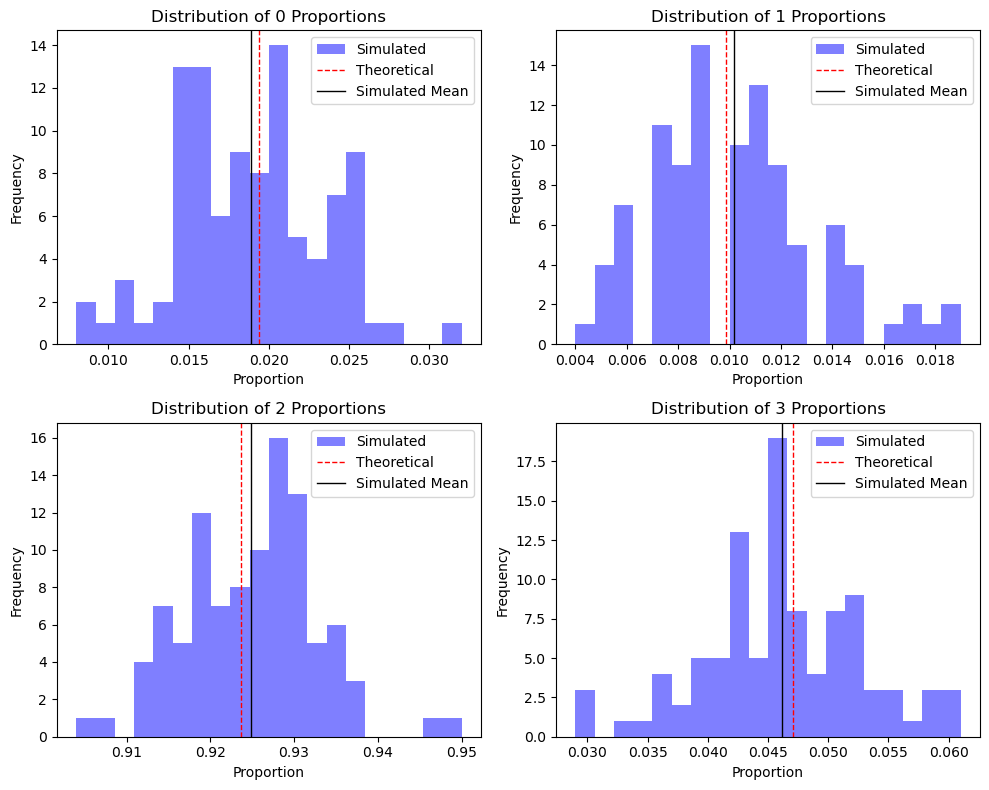

In [ ]:
plot_histograms(A_theo_df, A_sim_df)

### Simulation statistics:

In [ ]:
A_theo_df

,0,1,2,3
0,0.019407,0.009869,0.923614,0.047111


In [ ]:
A_sim_df

,0,1,2,3
1,0.017,0.012,0.927,0.044
2,0.022,0.012,0.920,0.046
3,0.015,0.006,0.938,0.041
4,0.019,0.005,0.937,0.039
5,0.018,0.010,0.911,0.061
...,...,...,...,...
96,0.016,0.013,0.929,0.042
97,0.021,0.008,0.926,0.045
98,0.022,0.019,0.929,0.030
99,0.009,0.012,0.950,0.029


In [ ]:
generate_stats(A_theo_df, A_sim_df)

Mean Simulated Proportion for 0: 0.018869999999999998
Theoretical Probability for 0: 0.019406581873457375
Standard Error for 0: 0.00044690970321563037
Z-score for 0: -1.2006494144041457

Mean Simulated Proportion for 1: 0.010159999999999997
Theoretical Probability for 1: 0.009868527666658427
Standard Error for 1: 0.00032496153618543846
Z-score for 1: 0.8969441022559748

Mean Simulated Proportion for 2: 0.92485
Theoretical Probability for 2: 0.9236135683026526
Standard Error for 2: 0.0007788070390285411
Z-score for 2: 1.5875969725307235

Mean Simulated Proportion for 3: 0.04612
Theoretical Probability for 3: 0.0471113221572316
Standard Error for 3: 0.0006697323451509672
Z-score for 3: -1.4801766174338504



In [ ]:
#generate_z_score(A_theo_df, A_sim_df)

## Simulation 2: Different starting sequence, independent

In [ ]:
def count_change_props(starting_seq, final_seq):
    """ 
    Input:
        starting_seq (list): Starting DNA sequence.
        final_seq (list): Final DNA sequence after one run of simulation.

    Output:
        changes_proportions (dict): A dictionary of proportions of each possible transition.
    """
    changes_counter = Counter(zip(starting_seq, final_seq))
    changes_proportions = {}

    nucleotide_counts = {'0': 0, '1': 0, '2': 0, '3': 0}
    nucleotide_counts.update(Counter(starting_seq)) # Update counts based on the starting sequence

    seq_length = len(starting_seq)

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            key = f"{from_nucleotide}_to_{to_nucleotide}"
            count = changes_counter[(from_nucleotide, to_nucleotide)]
            proportion = count / seq_length
            changes_proportions[key] = proportion

    return changes_proportions

# # Example usage:
# starting_seq = '0000000000'
# final_seq = '0123020010'
# proportions = count_change_props(starting_seq, final_seq)
# print(proportions)


In [ ]:
def simulation2(repeat, n, pi, max_time, rate_matrices_dict, markov_order):
    """ 
    Input:
        repeat (int): Number of times to repeat the simulation.
        n (int): Length of DNA sequence.
        pi (list): List of probabilities for each nucleotide. 
        max_time (float): Maximum time allowed for DNA substitutions to take place for each repeat.
        rate_matrices_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): Markov order.

    Output:
        theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition.
        sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat.
    """

    rate_mat_Q = rate_matrices_dict['0']
    trans_mat_P = transition_matrix(rate_mat_Q, max_time)
    pi_diag = np.diag(pi)
    joint_mat_J = np.dot(pi_diag, trans_mat_P) 
    theo_probs_dict = {}
    for i in range(4):
        for j in range(4):
            theo_probs_dict[f'{i}_to_{j}'] = joint_mat_J[i,j]

    simulated_props = {}

    for i in range(repeat):
        ancestor_seq = generate_ancestor(n, pi) # new ancestor every run
        simulation_results = simulate_seq(ancestor_seq,max_time,rate_matrices_dict,markov_order)
        final_seq = simulation_results[0]
        change_props = count_change_props(ancestor_seq, final_seq)
        simulated_props[i+1] = change_props

    theo_probs_df = pd.DataFrame([theo_probs_dict])
    sim_props_df = pd.DataFrame.from_dict(simulated_props, orient='index')
        
    return theo_probs_df, sim_props_df

In [ ]:
num_repeat = 100
n = 1000
pi = [0.1,0.4,0.3,0.2]
max_time = 0.2
order = 0 # independent
rate_matrices_dict = {'0': np.array([[-0.6, 0.1, 0.2, 0.3],
                                     [0.1, -0.65, 0.15, 0.4],
                                     [0.2, 0.1, -0.8, 0.5],
                                     [0.3, 0.2, 0.1, -0.6]])}


mix_theo_df, mix_sim_df = simulation2(num_repeat, n, pi, max_time, rate_matrices_dict, order)


In [ ]:
def plot_histograms2(theo_probs_df, simulated_props_df):
    columns = []

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            col_name = f"{from_nucleotide}_to_{to_nucleotide}"
            columns.append(col_name)

    bins = 20

    # Set up a 4x4 grid for subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    for i, col in enumerate(columns):
        row, col_num = divmod(i, 4)
        ax = axs[row, col_num]

        ax.hist(simulated_props_df[col], bins=bins, alpha=0.5, label='Simulated', color='pink')
        ax.axvline(x=theo_probs_df[col][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=simulated_props_df[col].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        # ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'Distribution of {col} Proportions')
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return

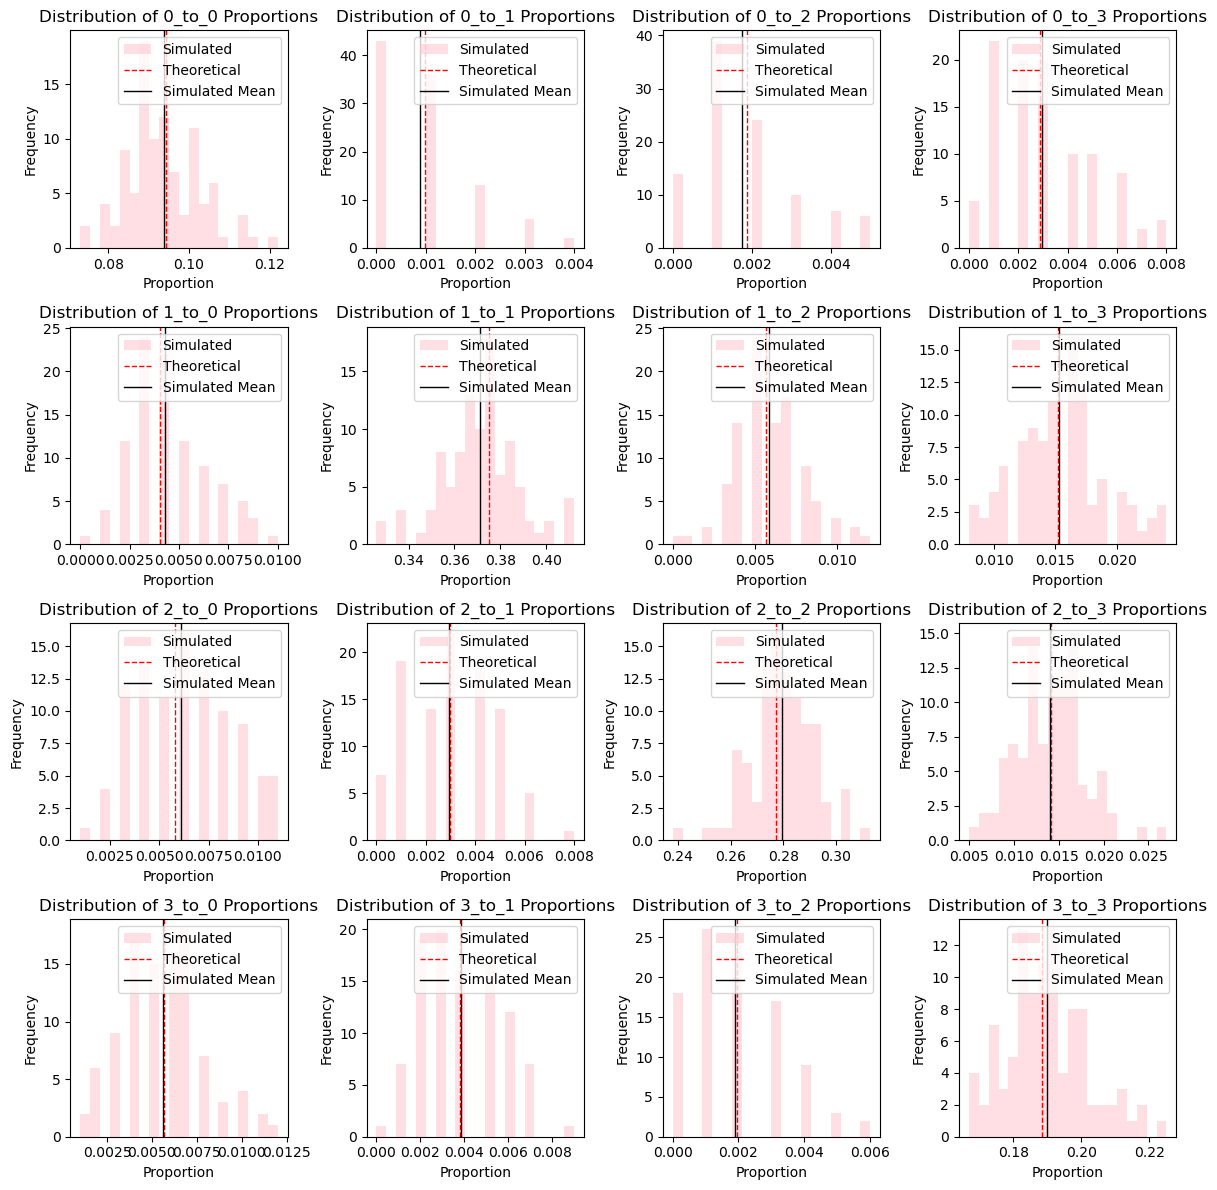

In [ ]:
plot_histograms2(mix_theo_df, mix_sim_df)

### Simulation Statistics

In [ ]:
mix_theo_df

,0_to_0,0_to_1,0_to_2,0_to_3,1_to_0,1_to_1,1_to_2,1_to_3,2_to_0,2_to_1,2_to_2,2_to_3,3_to_0,3_to_1,3_to_2,3_to_3
0,0.094243,0.000978,0.001887,0.002892,0.004043,0.375027,0.005696,0.015235,0.005822,0.002961,0.277084,0.014133,0.005691,0.003797,0.00195,0.188562


In [ ]:
mix_sim_df

,0_to_0,0_to_1,0_to_2,0_to_3,1_to_0,1_to_1,1_to_2,1_to_3,2_to_0,2_to_1,2_to_2,2_to_3,3_to_0,3_to_1,3_to_2,3_to_3
1,0.101,0.000,0.001,0.002,0.000,0.383,0.001,0.019,0.006,0.001,0.285,0.013,0.004,0.002,0.001,0.181
2,0.090,0.000,0.000,0.003,0.009,0.367,0.006,0.009,0.008,0.004,0.260,0.010,0.002,0.004,0.003,0.225
3,0.087,0.001,0.001,0.002,0.004,0.387,0.005,0.014,0.006,0.005,0.264,0.012,0.004,0.006,0.001,0.201
4,0.090,0.000,0.000,0.001,0.005,0.384,0.005,0.014,0.011,0.005,0.285,0.010,0.012,0.002,0.000,0.176
5,0.102,0.000,0.000,0.000,0.002,0.371,0.007,0.020,0.007,0.006,0.272,0.014,0.009,0.003,0.000,0.187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.090,0.001,0.000,0.001,0.004,0.390,0.007,0.011,0.002,0.003,0.280,0.015,0.003,0.002,0.004,0.187
97,0.089,0.000,0.003,0.007,0.003,0.329,0.011,0.018,0.003,0.003,0.288,0.018,0.004,0.002,0.003,0.219
98,0.093,0.000,0.000,0.005,0.002,0.356,0.004,0.016,0.003,0.000,0.286,0.012,0.006,0.007,0.000,0.210
99,0.094,0.001,0.002,0.005,0.006,0.367,0.005,0.017,0.008,0.000,0.281,0.016,0.002,0.005,0.001,0.190


In [ ]:
generate_stats(mix_theo_df, mix_sim_df)

Mean Simulated Proportion for 0_to_0: 0.09377
Theoretical Probability for 0_to_0: 0.09424318409273408
Standard Error for 0_to_0: 0.0009282170374900844
Z-score for 0_to_0: -0.5097774266388928

Mean Simulated Proportion for 0_to_1: 0.0008800000000000001
Theoretical Probability for 0_to_1: 0.0009776981649529052
Standard Error for 0_to_1: 9.875998862664658e-05
Z-score for 0_to_1: -0.9892484427296196

Mean Simulated Proportion for 0_to_2: 0.0017500000000000005
Theoretical Probability for 0_to_2: 0.0018867087754154772
Standard Error for 0_to_2: 0.00013512059708858508
Z-score for 0_to_2: -1.0117537841092463

Mean Simulated Proportion for 0_to_3: 0.0029800000000000004
Theoretical Probability for 0_to_3: 0.0028924089668975524
Standard Error for 0_to_3: 0.00019642255008480613
Z-score for 0_to_3: 0.445931656343074

Mean Simulated Proportion for 1_to_0: 0.004280000000000001
Theoretical Probability for 1_to_0: 0.004042794836315291
Standard Error for 1_to_0: 0.00020551978940818293
Z-score for 1_to_0

In [ ]:
def simulate_probability_distirbution():
    # Generate random numbers
    random_probs = np.random.rand(4)
    
    # Ensure each probability is at least min_prob
    random_probs = np.max([random_probs, np.full(4, 0.01)], axis=0) #minimal proportion is 0.01
    
    # Normalize the sum to 1
    total_sum = np.sum(random_probs)
    normalized_probs = random_probs / total_sum
    
    # Ensure the sum is exactly 1 by normalizing a second time if necessary
    if np.sum(normalized_probs) != 1:
        normalized_probs[-1] = 1 - np.sum(normalized_probs[:-1])
    
    return normalized_probs

In [ ]:
def multiple_independent_simulations(simulation, repeat, n, max_time):
    simulation_dict = {}
    for i in range(simulation):
        pi = simulate_probability_distirbution()
        Q_dict = {'0': generate_rate_matrix()}
        markov_order = 0
        theo_probs_df, sim_props_df = simulation2(repeat, n, pi, max_time, Q_dict, markov_order)
        simulation_dict[i] = [theo_probs_df, sim_props_df]

    return(simulation_dict)



In [ ]:
simulation_time = 5
repeat_time = 100
n1 = 1000
max_time1 = 0.2


In [ ]:
simulation_dict1 = multiple_independent_simulations(simulation_time, repeat_time, n1, max_time1)

In [ ]:
simulation_stat_dict = {}
for key, value in simulation_dict1.items():
    stats = generate_stats(value['theo_probs_df'], value['sim_props_df'])
    simulation_stat_dict[key] = stats


{0: {'theo_probs_df':      0_to_0   0_to_1   0_to_2    0_to_3    1_to_0    1_to_1   1_to_2  \
  0  0.042508  0.09201  0.05029  0.104494  0.024044  0.092466  0.04343   
  
       1_to_3    2_to_0    2_to_1    2_to_2    2_to_3   3_to_0    3_to_1  \
  0  0.084918  0.040271  0.101936  0.065359  0.113733  0.00976  0.044964   
  
      3_to_2    3_to_3  
  0  0.02117  0.068646  ,
  'sim_props_df':      0_to_0  0_to_1  0_to_2  0_to_3  1_to_0  1_to_1  1_to_2  1_to_3  2_to_0  \
  1     0.048   0.090   0.041   0.101   0.023   0.096   0.048   0.098   0.040   
  2     0.031   0.096   0.055   0.099   0.020   0.093   0.045   0.093   0.032   
  3     0.030   0.097   0.052   0.092   0.024   0.092   0.055   0.080   0.038   
  4     0.053   0.079   0.060   0.092   0.021   0.109   0.034   0.079   0.057   
  5     0.049   0.085   0.045   0.101   0.026   0.089   0.040   0.094   0.041   
  ..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
  96    0.045   0.089   0.044   0.091   

In [ ]:
# stat_dict = {}
# for key, value in simulation_dict1.items():
#     stat_dict[key] = generate_stats(value['theo_probs_df'], value['sim_props_df'])




In [ ]:
simulation_time2 = 20
repeat_time2 = 100
n2 = 1000
max_time2 = 0.2
simulation_dict2 = multiple_independent_simulations(simulation_time2, repeat_time2, n2, max_time2)

## Simple context dependent, CpG effect

In [ ]:
def CpG_rate_matrices(rate_matrix, markov_order = 1):
    """
    Input:
        rate_matrix (array): A single rate matrix.

    Output: 
        rate_matrices (dict): A dictionary of rate matrices for CpG context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
    """
    rate_matrices = {}
    
    nucleotides = ['0', '1', '2', '3']
    one_side_neighbours = [''.join(p) for p in itertools.product(nucleotides, repeat=markov_order)]
    permutations = list(itertools.product(one_side_neighbours, repeat=2))
    
    modified_rate_matrix = rate_matrix.copy()
    modified_rate_matrix[1,0] *= 10 # third row, first column contains rate for C changing to T

    for perm in permutations:
        if perm[1] == '3':
            # rates multiplied by 10 if right neighbour is G ( coded '3')
            rate_matrices[perm] = modified_rate_matrix
        else:
            rate_matrices[perm] = rate_matrix

    return rate_matrices

In [ ]:
rate_matrix = np.array([[-0.6, 0.1, 0.2, 0.3],
                        [0.1, -0.65, 0.15, 0.4],
                        [0.2, 0.1, -0.8, 0.5],
                        [0.3, 0.2, 0.1, -0.6]])

rate_matrices_dict = CpG_rate_matrices(rate_matrix)
rate_matrices_dict

{('0',
  '0'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('0',
  '1'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('0',
  '2'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('0',
  '3'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 1.  , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('1',
  '0'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0.6 ]]),
 ('1',
  '1'): array([[-0.6 ,  0.1 ,  0.2 ,  0.3 ],
        [ 0.1 , -0.65,  0.15,  0.4 ],
        [ 0.2 ,  0.1 , -0.8 ,  0.5 ],
        [ 0.3 ,  0.2 ,  0.1 , -0

In [ ]:
def CpG_change_props(starting_seq, final_seq):
    """ 
    Input:
        starting_seq (list): Starting DNA sequence.
        final_seq (list): Final DNA sequence after one run of simulation.

    Output:
        CpG_props_dict (dict): A dictionary of proportions of each possible transition for CpG context.
        non_CpG_props_dict (dict): A dictionary of proportions of each possible transition for non_CpG context.
    """

    seq_length = len(starting_seq)

    start_context_dict = {} # Dictionary of context for all nucleotides in starting DNA sequence.
    for i in range(seq_length):
        start_context_dict[i] = get_context(i,starting_seq,markov_order=1) 

    final_context_dict = {} # Dictionary of context for all nucleotides in final DNA sequence.
    for i in range(seq_length):
        final_context_dict[i] = get_context(i,final_seq,markov_order=1) 

    # Initializing matrices to store simulated probabilities
    CpG_props = np.zeros((4,4))
    non_CpG_props = np.zeros((4,4))

    for i in range(seq_length):
        if (start_context_dict[i] == final_context_dict[i]): # Contexts that appears to remain unchanged 
            start_base = int(starting_seq[i])
            final_base = int(final_seq[i])
            if start_context_dict[i][1] == '3': # Contexts with G / '3' as right neighbour
                CpG_props[start_base, final_base] += 1
            else:
                non_CpG_props[start_base, final_base] += 1

    # Normalizing the matrices to obtain the proportions
    CpG_props /= np.sum(CpG_props)
    non_CpG_props /= np.sum(non_CpG_props)

    # Creating dictionaries to store simulated proportions to prepare for pandas dataframe
    CpG_props_dict = {}
    non_CpG_props_dict = {}
    for i in range(4):
        for j in range(4):
            CpG_props_dict[f'CpG_{i}_to_{j}'] = CpG_props[i,j]
            non_CpG_props_dict[f'non_CpG_{i}_to_{j}'] = non_CpG_props[i,j]

    return CpG_props_dict, non_CpG_props_dict

In [ ]:
def CpG_simulation(repeat, n, pi, max_time, rate_matrices_dict, markov_order = 1):
    """ 
    Input:
        repeat (int): Number of times to repeat the simulation.
        n (int): Length of DNA sequence.
        pi (list): List of probabilities for each nucleotide. 
        max_time (float): Maximum time allowed for DNA substitutions to take place for each repeat.
        rate_matrices_dict (dict): A dictionary of rate matrices for context-dependent DNA substitution. 
            The key is a tuple of left and right neighbours as strings from permutations with [0, 1, 2, 3] (=[T, C, A, G]). 
            The value is the corresponding rate matrix.
        markov_order (int): Markov order.

    Output:
        CpG_theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition for CpG context.
        CpG_sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat, for CpG context.
        non_CpG_theo_probs_df (dataframe): Dataframe containing all the theoretical propbabilities of each transition for non-CpG context.
        non_CpG_sim_props_df (dataframe): Dataframe containing all the simulated proportions of each transition, each row representing one repeat, for non-CpG context.
    """

    ancestor_seq = generate_ancestor(n,pi=pi)
    
    # To simplify the number rate matrices since in the 16 matrices, there are actually only 2 different types.
    # One for CpG contexts, another non_CpG
    CpG_context = ('0', '3')
    non_CpG_context = ('0', '0')
    
    CpG_Q = rate_matrices_dict[CpG_context]
    CpG_P = transition_matrix(CpG_Q, max_time)

    non_CpG_Q = rate_matrices_dict[non_CpG_context]
    non_CpG_P = transition_matrix(non_CpG_Q, max_time)
    
    pi_diag = np.diag(pi)

    CpG_J = np.dot(pi_diag, CpG_P) 
    non_CpG_J = np.dot(pi_diag, non_CpG_P)

    CpG_theo_probs_dict = {}
    non_CpG_theo_probs_dict = {}

    for i in range(4):
        for j in range(4):
            CpG_theo_probs_dict[f'CpG_{i}_to_{j}'] = CpG_J[i,j]
            non_CpG_theo_probs_dict[f'non_CpG_{i}_to_{j}'] = non_CpG_J[i,j]

    CpG_sim_props_dict = {}
    non_CpG_sim_props_dict = {}

    for i in range(repeat):
        simulation_results = simulate_seq(ancestor_seq,max_time,rate_matrices_dict,markov_order)
        final_seq = simulation_results[0]
        CpG_sim_props, non_CpG_sim_props = CpG_change_props(ancestor_seq, final_seq)
        CpG_sim_props_dict[i+1] = CpG_sim_props
        non_CpG_sim_props_dict[i+1] = non_CpG_sim_props

    CpG_theo_probs_df = pd.DataFrame([CpG_theo_probs_dict])
    non_CpG_theo_probs_df = pd.DataFrame([non_CpG_theo_probs_dict])
    CpG_sim_props_df = pd.DataFrame.from_dict(CpG_sim_props_dict, orient='index')
    non_CpG_sim_props_df = pd.DataFrame.from_dict(non_CpG_sim_props_dict, orient='index')
        
    return CpG_theo_probs_df, CpG_sim_props_df, non_CpG_theo_probs_df, non_CpG_sim_props_df

In [ ]:
num_repeat = 100
n = 1000
pi = [0.1,0.4,0.3,0.2]
max_time = 0.1
order = 1 # default for CpG
rate_matrix = np.array([[-0.6, 0.1, 0.2, 0.3],
                        [0.1, -0.65, 0.15, 0.4],
                        [0.2, 0.1, -0.8, 0.5],
                        [0.3, 0.2, 0.1, -0.6]])
rate_matrices_dict = CpG_rate_matrices(rate_matrix) # 16 rate matrices, of which 12 baselines and 4 test

In [ ]:
CpG_theo_df, CpG_sim_df, non_CpG_theo_df, non_CpG_sim_df = CpG_simulation(num_repeat, n, pi, max_time, rate_matrices_dict)

In [ ]:
CpG_theo_df

,CpG_0_to_0,CpG_0_to_1,CpG_0_to_2,CpG_0_to_3,CpG_1_to_0,CpG_1_to_1,CpG_1_to_2,CpG_1_to_3,CpG_2_to_0,CpG_2_to_1,CpG_2_to_2,CpG_2_to_3,CpG_3_to_0,CpG_3_to_1,CpG_3_to_2,CpG_3_to_3
0,0.094287,0.000978,0.001887,0.002893,0.037881,0.3752,0.006035,0.01575,0.005953,0.002961,0.277085,0.014135,0.005861,0.003798,0.001951,0.188564


In [ ]:
CpG_sim_df

,CpG_0_to_0,CpG_0_to_1,CpG_0_to_2,CpG_0_to_3,CpG_1_to_0,CpG_1_to_1,CpG_1_to_2,CpG_1_to_3,CpG_2_to_0,CpG_2_to_1,CpG_2_to_2,CpG_2_to_3,CpG_3_to_0,CpG_3_to_1,CpG_3_to_2,CpG_3_to_3
1,0.112426,0.000000,0.000000,0.000000,0.041420,0.366864,0.005917,0.023669,0.000000,0.000000,0.248521,0.011834,0.000000,0.000000,0.000000,0.189349
2,0.110497,0.000000,0.000000,0.000000,0.016575,0.408840,0.005525,0.000000,0.000000,0.000000,0.237569,0.011050,0.000000,0.000000,0.000000,0.209945
3,0.109195,0.000000,0.000000,0.005747,0.068966,0.373563,0.005747,0.011494,0.000000,0.000000,0.241379,0.011494,0.000000,0.011494,0.005747,0.155172
4,0.101124,0.005618,0.000000,0.005618,0.028090,0.370787,0.005618,0.016854,0.005618,0.000000,0.269663,0.011236,0.011236,0.000000,0.000000,0.168539
5,0.097561,0.006098,0.000000,0.000000,0.054878,0.359756,0.000000,0.018293,0.000000,0.012195,0.243902,0.012195,0.018293,0.006098,0.000000,0.170732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.093023,0.000000,0.000000,0.011628,0.058140,0.343023,0.000000,0.023256,0.005814,0.005814,0.244186,0.011628,0.000000,0.000000,0.000000,0.203488
97,0.093023,0.000000,0.000000,0.005814,0.034884,0.406977,0.005814,0.005814,0.000000,0.000000,0.238372,0.017442,0.011628,0.011628,0.000000,0.168605
98,0.106145,0.000000,0.011173,0.000000,0.039106,0.368715,0.005587,0.005587,0.000000,0.000000,0.290503,0.011173,0.005587,0.000000,0.011173,0.145251
99,0.108571,0.000000,0.005714,0.000000,0.051429,0.365714,0.000000,0.034286,0.000000,0.000000,0.222857,0.022857,0.005714,0.005714,0.000000,0.177143


In [ ]:
def CpG_histograms(hypo_probs_df, simulated_props_df):
    columns = []

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            col_name = f"CpG_{from_nucleotide}_to_{to_nucleotide}"
            columns.append(col_name)

    bins = 20

    # Set up a 4x4 grid for subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    for i, col in enumerate(columns):
        row, col_num = divmod(i, 4)
        ax = axs[row, col_num]

        ax.hist(simulated_props_df[col], bins=bins, alpha=0.5, label='Simulated', color='pink')
        ax.axvline(x=hypo_probs_df[col][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=simulated_props_df[col].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        # ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{col} Proportions')
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return

In [ ]:
def non_CpG_histograms(hypo_probs_df, simulated_props_df):
    columns = []

    for from_nucleotide in '0123':
        for to_nucleotide in '0123':
            col_name = f"non_CpG_{from_nucleotide}_to_{to_nucleotide}"
            columns.append(col_name)

    bins = 20

    # Set up a 4x4 grid for subplots
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))

    for i, col in enumerate(columns):
        row, col_num = divmod(i, 4)
        ax = axs[row, col_num]

        ax.hist(simulated_props_df[col], bins=bins, alpha=0.5, label='Simulated', color='pink')
        ax.axvline(x=hypo_probs_df[col][0], color='red', linestyle='dashed', linewidth=1, label='Theoretical')
        ax.axvline(x=simulated_props_df[col].mean(), color='black', linestyle='solid', linewidth=1, label='Simulated Mean')
        # ax.set_xlim(0, 1)  # Set x-axis range from 0 to 1
        ax.set_xlabel('Proportion')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{col} Proportions')
        ax.legend()

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

    return

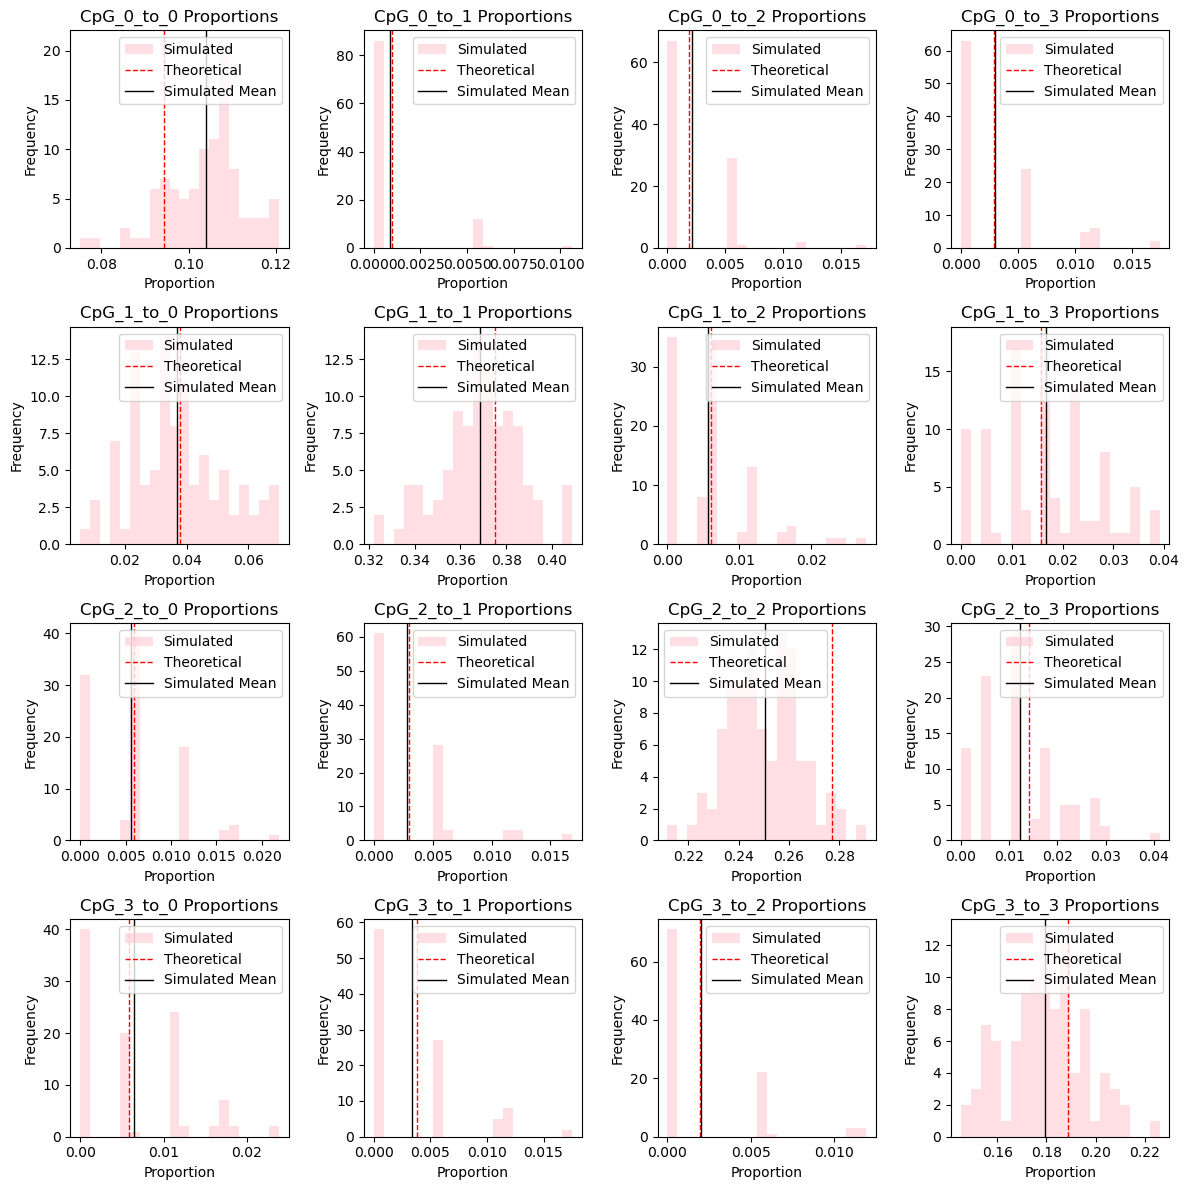

In [ ]:
CpG_histograms(CpG_theo_df, CpG_sim_df)

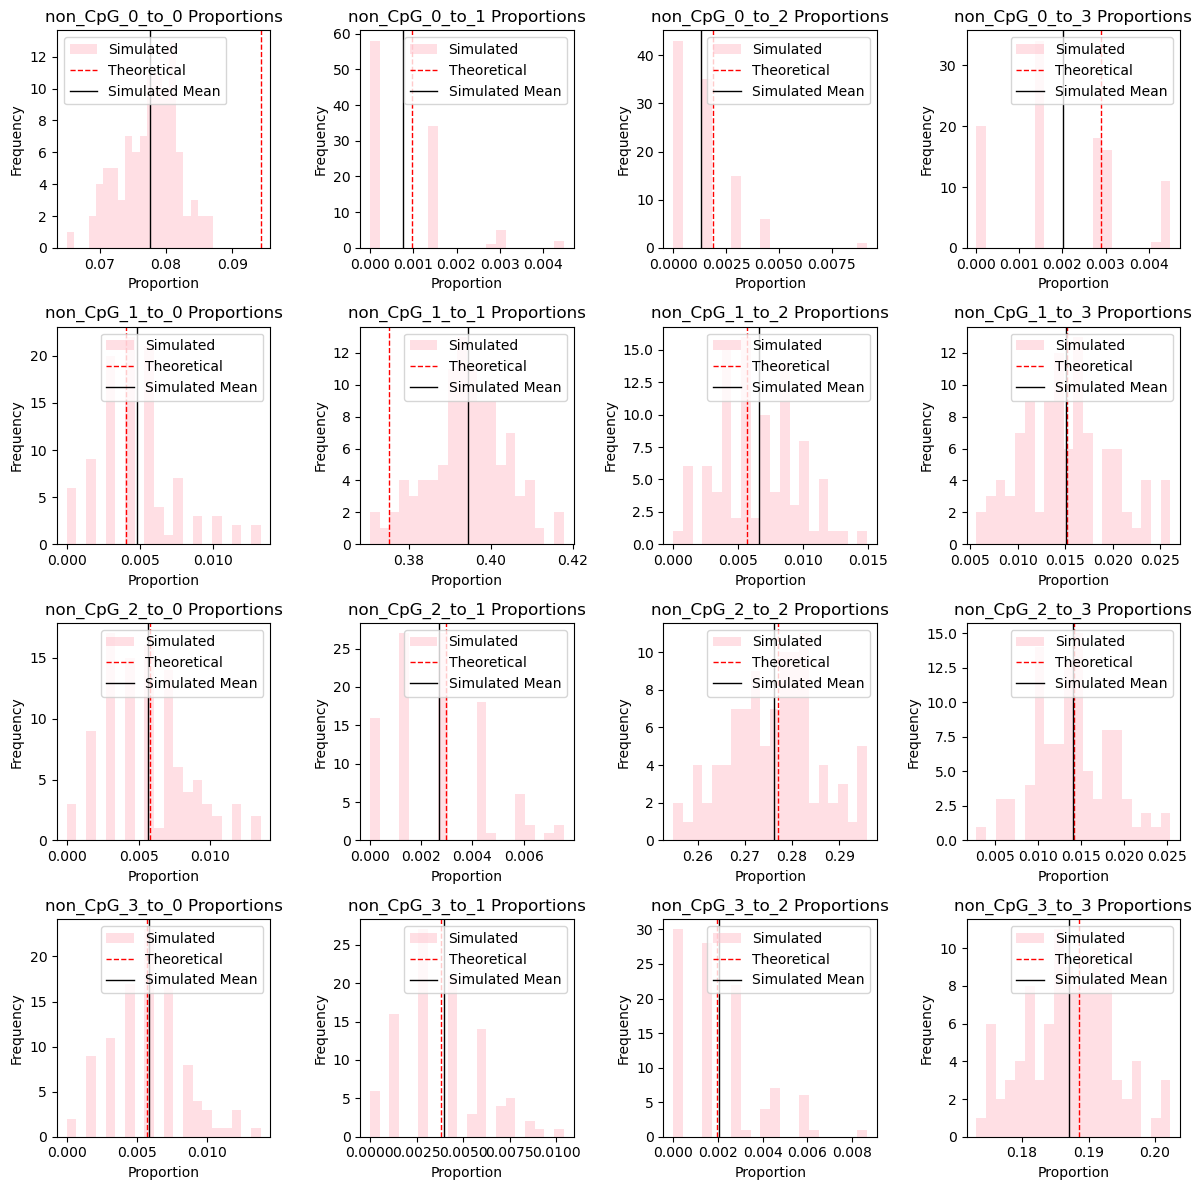

In [ ]:
non_CpG_histograms(non_CpG_theo_df, non_CpG_sim_df)

### Simulation Statistics

CpG Statistics

In [ ]:
generate_stats(CpG_theo_df, CpG_sim_df)

Mean Simulated Proportion for CpG_0_to_0: 0.10394179524880326
Theoretical Probability for CpG_0_to_0: 0.09428664516391436
Standard Error for CpG_0_to_0: 0.0008762549340676091
Z-score for CpG_0_to_0: 11.018654171873617

Mean Simulated Proportion for CpG_0_to_1: 0.0008492034392223027
Theoretical Probability for CpG_0_to_1: 0.000977844829373965
Standard Error for CpG_0_to_1: 0.00021692531502001772
Z-score for CpG_0_to_1: -0.5930215666151796

Mean Simulated Proportion for CpG_0_to_2: 0.0021057728096108056
Theoretical Probability for CpG_0_to_2: 0.0018869968873143472
Standard Error for CpG_0_to_2: 0.00033008022652156524
Z-score for CpG_0_to_2: 0.6627962074612945

Mean Simulated Proportion for CpG_0_to_3: 0.002957496176986039
Theoretical Probability for CpG_0_to_3: 0.0028928458827569316
Standard Error for CpG_0_to_3: 0.0004399856858704641
Z-score for CpG_0_to_3: 0.14693726706404983

Mean Simulated Proportion for CpG_1_to_0: 0.036968626361367114
Theoretical Probability for CpG_1_to_0: 0.03788

non_CpG Statistics

In [ ]:
generate_stats(non_CpG_theo_df, non_CpG_sim_df)

Mean Simulated Proportion for non_CpG_0_to_0: 0.07756896142790877
Theoretical Probability for non_CpG_0_to_0: 0.09424318409273408
Standard Error for non_CpG_0_to_0: 0.00043392445201831343
Z-score for non_CpG_0_to_0: -38.42655694388383

Mean Simulated Proportion for non_CpG_0_to_1: 0.0007624942675067265
Theoretical Probability for non_CpG_0_to_1: 0.0009776981649529052
Standard Error for non_CpG_0_to_1: 0.00010349220145454436
Z-score for non_CpG_0_to_1: -2.0794213904194527

Mean Simulated Proportion for non_CpG_0_to_2: 0.0013032682237314691
Theoretical Probability for non_CpG_0_to_2: 0.0018867087754154772
Standard Error for non_CpG_0_to_2: 0.00015295487529758128
Z-score for non_CpG_0_to_2: -3.8144619486557434

Mean Simulated Proportion for non_CpG_0_to_3: 0.0020175343600221116
Theoretical Probability for non_CpG_0_to_3: 0.0028924089668975524
Standard Error for non_CpG_0_to_3: 0.00013754189511098382
Z-score for non_CpG_0_to_3: -6.3607863347345655

Mean Simulated Proportion for non_CpG_1_t